In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import lstsq

In [2]:
#res in mm
res_mm = 1
#res in cm
res = 0.1
#fov in cm
fov_x = 10
fov_y = 10

pixels_x = int(fov_x/res)
pixels_y = int(fov_y/res)
pixels = pixels_x*pixels_y

t1_myelin = 400*10^-3
t1_wm = 850*10^-3
t2_myelin = 50*10^-3
t2_wm = 50*10^-3
t2_star_myelin = 30*10^-3
t2_star_wm = 70*10^-3
inv_time = np.log(2)*t1_wm
echo_time = 5*10^-5

0.45138745911337647
0.0
0.22569372955668823


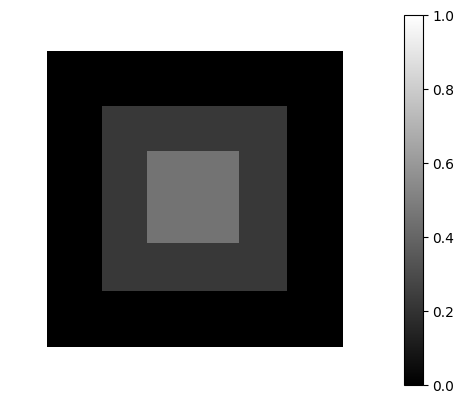

In [3]:
image = np.ones((pixels_x, pixels_y))

mxy_myelin = (1-2*np.exp(-(inv_time/t1_myelin)))*np.exp(-(echo_time/t2_star_myelin))
mxy_wm = (1-2*np.exp(-(inv_time/t1_wm)))*np.exp(-(echo_time/t2_star_wm))
mxy_mixed = 0.5*((1-2*np.exp(-(inv_time/t1_wm)))*np.exp(-(echo_time/t2_star_wm))) + 0.5*((1-2*np.exp(-(inv_time/t1_myelin)))*np.exp(-(echo_time/t2_star_myelin)))

print(mxy_myelin)
print(mxy_wm)
print(mxy_mixed)

outer_square_size = int(0.8 * pixels_x)  # 80% of image size
middle_square_size = int(0.5 * pixels_x)  # 60% of image size
inner_square_size = int(0.25 * pixels_x)  # 40% of image size

# Calculate starting and ending indices for each square to center them
outer_start = (pixels_x - outer_square_size) // 2
outer_end = outer_start + outer_square_size

middle_start = (pixels_x - middle_square_size) // 2
middle_end = middle_start + middle_square_size

inner_start = (pixels_x - inner_square_size) // 2
inner_end = inner_start + inner_square_size

# Define the intensity values for each section
# Outermost square (100% WM - white, intensity = 1)
image[outer_start:outer_end, outer_start:outer_end] = mxy_wm  # 100% WM

# Middle square (50/50 of WM and myelin - medium gray)
image[middle_start:middle_end, middle_start:middle_end] = mxy_mixed  # 50/50 of WM and myelin (gray)

# Innermost square (100% myelin - black, intensity = 0)
image[inner_start:inner_end, inner_start:inner_end] = mxy_myelin  # 100% myelin (black)

# Display the image using matplotlib
plt.imshow(image, cmap='gray', interpolation='nearest')
plt.axis('off')  # Turn off axis
plt.colorbar()
plt.show()

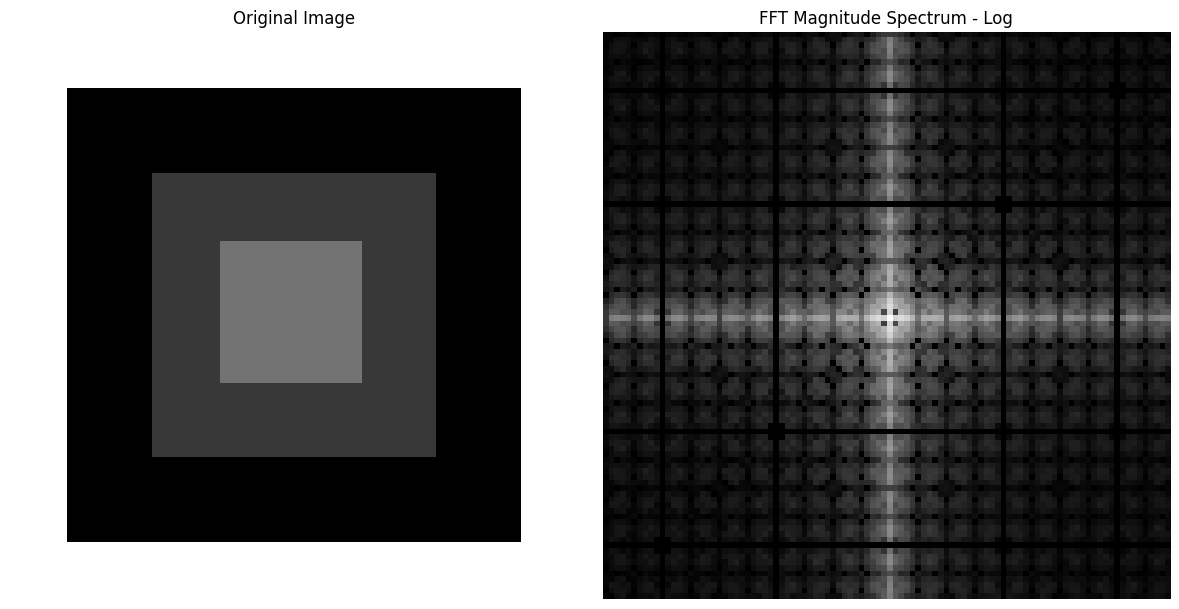

In [4]:
f_image = np.fft.fft2(image)

fft_image_shifted = np.fft.fftshift(f_image)  # Shift the zero-frequency component to the center

# Compute the magnitude spectrum
magnitude_spectrum = np.log(np.abs(fft_image_shifted) + 1)  # Log to enhance visibility

# Plot the original image and its FFT magnitude spectrum
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("FFT Magnitude Spectrum - Log")
plt.imshow(magnitude_spectrum, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

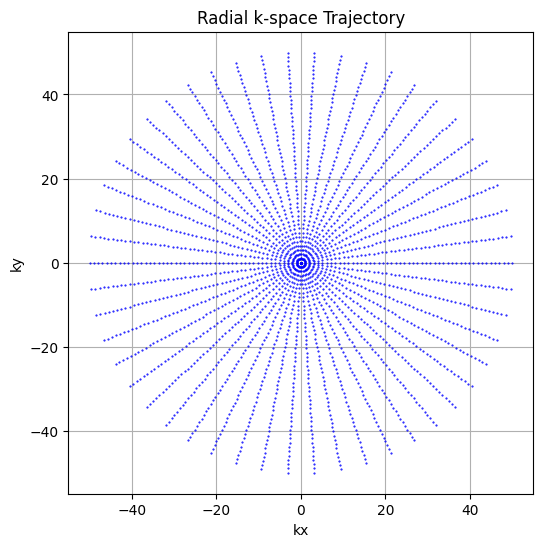

In [5]:
# Initialize an empty k-space grid (frequency space)
k_space = np.zeros((pixels_x, pixels_y), dtype=complex)

# Reset parameters for radial k-space sampling
#num_rays = int(np.pi*pixels_x*fov_x)+1 # Number of rays
num_rays = 50
num_samples_per_ray = 50  # Number of samples per ray

# Create radial k-space sampling points (rays)
angles = np.linspace(0, 2 * np.pi, num_rays, endpoint=False)  # Angle of the rays
radii = np.linspace(0, pixels_x // 2, num_samples_per_ray)  # Radial distance (from the center)

# Loop over each ray and sample k-space
for angle in angles:
    for radius in radii:
        # Calculate the kx, ky coordinates for each point along the ray
        kx = int(round(radius * np.cos(angle) + pixels_x // 2))  # x-coordinate in k-space, shifted to center
        ky = int(round(radius * np.sin(angle) + pixels_y // 2))  # y-coordinate in k-space, shifted to center

        # Clip the coordinates to stay within the image bounds
        kx = np.clip(kx, 0, pixels_x - 1)
        ky = np.clip(ky, 0, pixels_y - 1)

        # Accumulate the value of the phantom at this position
        k_space[kx, ky] += image[kx, ky] * 10  # Increase intensity to make visible

# Visualize the radial k-space sampling points (this shows the rays)
plt.figure(figsize=(6, 6))
for angle in angles:
    x_vals = np.linspace(0, 50 * np.cos(angle), num_samples_per_ray)
    y_vals = np.linspace(0, 50 * np.sin(angle), num_samples_per_ray)
    plt.plot(x_vals, y_vals, 'b.', markersize=1)
plt.title('Radial k-space Trajectory')
plt.xlabel('kx')
plt.ylabel('ky')
plt.axis('equal')
plt.grid(True)
plt.show()

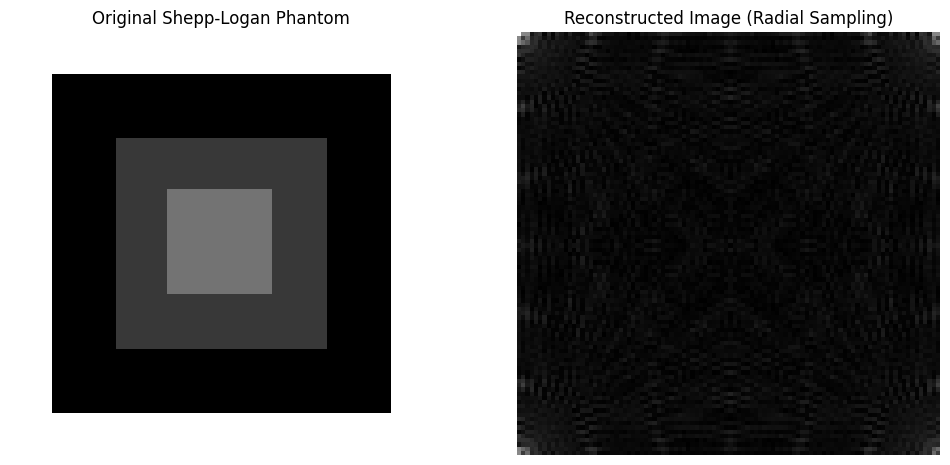

In [6]:
# Reconstruct the image using the inverse Fourier transform
reconstructed_image = np.abs(np.fft.ifft2(np.fft.fftshift(k_space)))

# Scale the reconstructed image for better contrast
reconstructed_image = np.log(1 + reconstructed_image)  # Log scaling to enhance visibility

# Plot the original and reconstructed images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Shepp-Logan Phantom')
ax[0].axis('off')

ax[1].imshow(reconstructed_image, cmap='gray')
ax[1].set_title('Reconstructed Image (Radial Sampling)')
ax[1].axis('off')

plt.show()


In [10]:
# Parameters
N_x = pixels_x  # Example value for the spatial dimension
N_k = num_rays*num_samples_per_ray

# Generate x- and y-coordinates with "isocentre" at the N_x/2+1 index
xidx, yidx = np.meshgrid(np.arange(-N_x/2, N_x/2), np.arange(-N_x/2, N_x/2))

# Loop over each k-location to construct the spatial phase modulation
F = np.zeros((N_k, N_x, N_x), dtype=complex)
for i in range(N_x):
    for j in range(N_x):
        # Get the corresponding kx, ky from k_space at (i, j)
        kx = k_space[i, j]  # Using k-space values directly
        ky = k_space[i, j]  # Assuming k-space values for both kx and ky

        # Compute the 2D Fourier exponential for the spatial modulation
        F[i, j] = np.exp(1j * 2 * np.pi * (kx * xidx[i, j] + ky * yidx[i, j]))  # Spatial phase modulation

# Reshape F so that each row is a single k-space encoding
F = F.reshape(N_k, -1)
reshaped_image = image.reshape(-1)
d = F*reshaped_image[:]
print(F.shape)
print(d.shape)

(2500, 10000)
(2500, 10000)


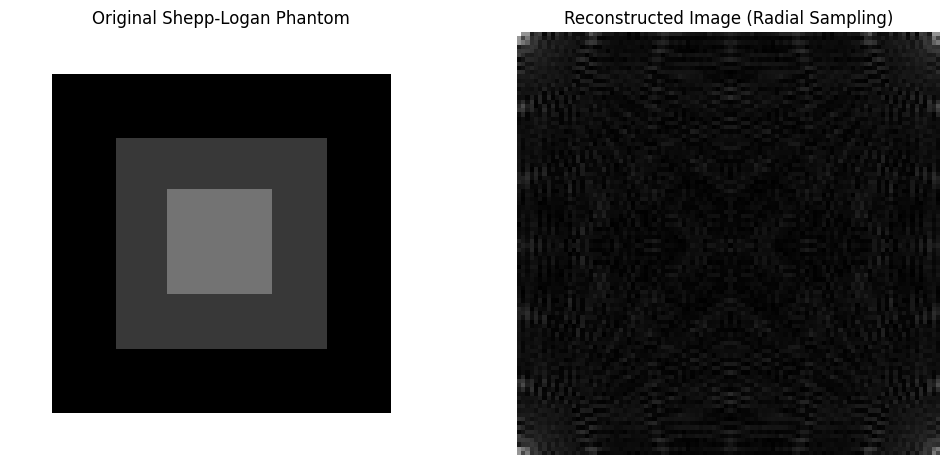

In [17]:
# Reconstruct the image using the inverse Fourier transform - following Mark Chiew
reconstructed_image_nc = np.abs(np.fft.ifft2(np.fft.fftshift(d)))

# Scale the reconstructed image for better contrast
reconstructed_image = np.log(1 + reconstructed_image)  # Log scaling to enhance visibility

# Plot the original and reconstructed images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Shepp-Logan Phantom')
ax[0].axis('off')

ax[1].imshow(reconstructed_image, cmap='gray')
ax[1].set_title('Reconstructed Image (Radial Sampling)')
ax[1].axis('off')

plt.show()

NRMSE: (0.6244223135480456+4.269961533436896e-06j)


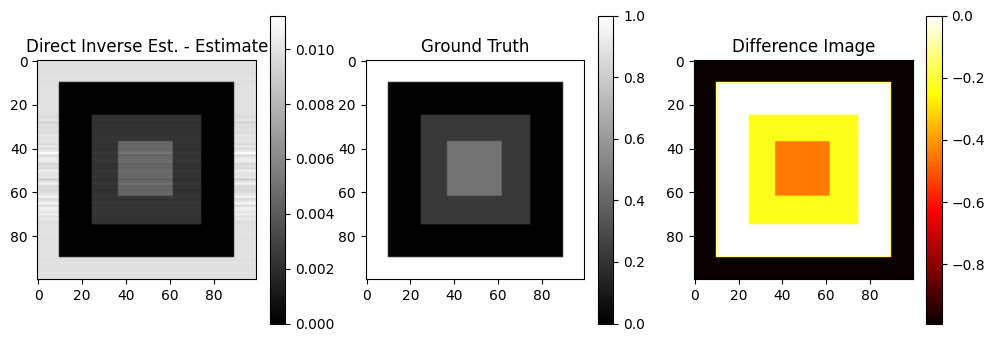

In [16]:
# Compute the naive inverse using NumPy (similar to F \ d in MATLAB)
#est0 = np.linalg.lstsq(F, d, rcond=None)[0]  # Least squares solution, equivalent to F\d in MATLAB

# Assuming F and d have shape (2500, 10000)
est0, _, _, _ = lstsq(F, d)  # Solve the least squares problem

est0 = est0[0].reshape((100, 100))
#print(est0)

# Function to compute NRMSE
def nrmse(estimate, truth):
    mse = np.mean((estimate - truth) ** 2)
    rmse = np.sqrt(mse)
    nrmse_value = rmse / (np.max(truth) - np.min(truth))
    print(f'NRMSE: {nrmse_value}')
    return nrmse_value

# Function to plot the estimated image, ground truth, and difference image
def plt_estimate(est, truth, N_x, title):
    est_image = np.abs(est.reshape(N_x, N_x))
    truth_image = np.abs(truth.reshape(N_x, N_x))
    diff_image = est_image - truth_image

    # Plotting
    plt.figure(figsize=(12, 4))

    # Plot estimate
    plt.subplot(1, 3, 1)
    plt.imshow(est_image, cmap='gray')
    plt.title(f'{title} - Estimate')
    plt.colorbar()

    # Plot truth
    plt.subplot(1, 3, 2)
    plt.imshow(truth_image, cmap='gray')
    plt.title('Ground Truth')
    plt.colorbar()

    # Plot difference
    plt.subplot(1, 3, 3)
    plt.imshow(diff_image, cmap='hot')
    plt.title('Difference Image')
    plt.colorbar()

    plt.show()

# Compute NRMSE
nrmse_value = nrmse(est0, image)

# Plot the results
plt_estimate(est0, image, N_x, 'Direct Inverse Est.')